## Import 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay


import warnings
warnings.filterwarnings('ignore')

## Load Data

In [5]:
preprocess_df = pd.read_csv('../data/preprocessing_data.csv')

## Feature Selection

In [6]:
X = preprocess_df.drop(columns = ['customer_id','location','payment_plan','payment_method','num_playlists_created','churned'])
y = preprocess_df['churned']

## Training set / Validation set / Test set

In [7]:
# 데이터를 70% 훈련 세트, 30% 임시 세트로 나누기
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# 임시 세트를 다시 50%로 나누어 15% 검증 세트, 15% 테스트 세트로 나누기
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

## RandomForest 

- 모델 정의

In [8]:
random_forest = RandomForestClassifier()

- RandomizedSearchCV

In [9]:
# 파라미터 분포 설정
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt']
}

# RandomizedSearchCV 수행
random_search = RandomizedSearchCV(estimator=random_forest, param_distributions=param_dist, 
                                   n_iter=50, scoring='accuracy', cv=3, verbose=1, random_state=42)
random_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print('최적 파라미터 : {}'.format(random_search.best_params_))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
최적 파라미터 : {'n_estimators': 400, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 30}


In [15]:
best_model = random_search.best_estimator_
dump(best_model, 'randomforest_best_model.joblib')

['randomforest_best_model.joblib']

- 테스트 세트 평가

In [16]:
loaded_model = load('randomforest_best_model.joblib')
y_pred = loaded_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"테스트 데이터 정확도: {accuracy}")

테스트 데이터 정확도: 0.8455466666666667


- 성능 평가

In [17]:
y_pred_prob = loaded_model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("AUC: {:.4f}".format(roc_auc))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

AUC: 0.9350
Precision: 0.8467
Recall: 0.8534
F1 Score: 0.8500

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.84      0.84      9132
           1       0.85      0.85      0.85      9618

    accuracy                           0.85     18750
   macro avg       0.85      0.85      0.85     18750
weighted avg       0.85      0.85      0.85     18750



- Confusion Matrix 시각화

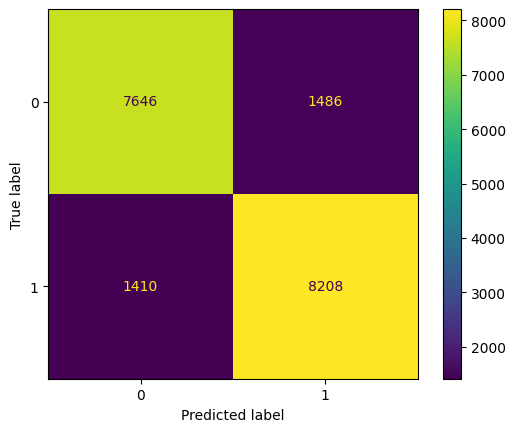

In [18]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

- ROC Curve 시각화

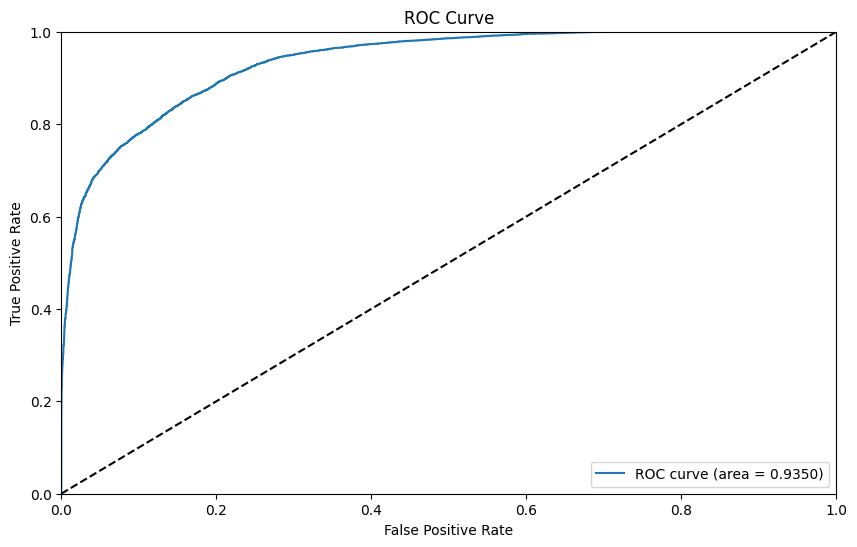

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label='ROC curve (area = {:.4f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()